In [1]:
library(tidyverse)
library(repr)
library(caret)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



After installing tidyverse, repr, and caret, we needed to first load our datasets in via the git clone command in our terminal of juptyer:

git clone https://github.com/UBC-DSCI/datasets.git

In [2]:
install.packages('e1071')
library(e1071)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


We are planning on using read_csv() to take in the dataset once it is cloned into our Jupyter hub. Let's first take a look at the dataset:

In [25]:
kidney_rough <- read_csv('datasets/chronic_kidney_disease/chronic_kidney_disease_full.csv')
glimpse(kidney_rough)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


Observations: 400
Variables: 25
$ age   <int> 48, 7, 62, 48, 51, 60, 68, 24, 52, 53, 50, 63, 68, 68, 68, 40...
$ bp    <int> 80, 50, 80, 70, 80, 90, 70, NA, 100, 90, 60, 70, 70, 70, 80, ...
$ sg    <dbl> 1.020, 1.020, 1.010, 1.005, 1.010, 1.015, 1.010, 1.015, 1.015...
$ al    <int> 1, 4, 2, 4, 2, 3, 0, 2, 3, 2, 2, 3, 3, NA, 3, 3, 2, NA, 0, 1,...
$ su    <int> 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 4, 0, 1, NA, 2, 0, 0, NA, 3, 0,...
$ rbc   <chr> NA, NA, "normal", "normal", "normal", NA, NA, "normal", "norm...
$ pc    <chr> "normal", "normal", "normal", "abnormal", "normal", NA, "norm...
$ pcc   <chr> "notpresent", "notpresent", "notpresent", "present", "notpres...
$ ba    <chr> "notpresent", "notpresent", "notpresent", "notpresent", "notp...
$ bgr   <int> 121, NA, 423, 117, 106, 74, 100, 410, 138, 70, 490, 380, 208,...
$ bu    <dbl> 36, 18, 53, 56, 26, 25, 54, 31, 60, 107, 55, 60, 72, 86, 90, ...
$ sc    <dbl> 1.2, 0.8, 1.8, 3.8, 1.4, 1.1, 24.0, 1.1, 1.9, 7.2, 4.0, 2.7, ...
$ sod   <dbl> NA, NA

### Description:

Chronic kidney disease (CKD) is the presence of kidney damage, or a decreased level of kidney function, for three months or more (The Kidney Foundation of Canada). To accurately diagnose CKD, a wide variety of blood and urine tests can be performed, and risk factors such as age, diabetes, and coronary heart disease can be useful for determining the progression of disease (Mayo Clinic). **Our goal in this research project is to determine of the data variables collected on CKD and non-CKD patients, which variable is the most important in categorizing a CKD vs. non-CKD patient.** Chronic Kidney Disease Data Set was collected from Apollo Hospital for a two months ending in July 2015. There are 25 attributes where 11 are numerical variables, and 14 are characteristic variables. (UCI Machine Learning Repository)

### Problems:
1) We have NA values in our class column, these are rows that are not useful to us when we are attempting to train our classifier. We need to remove these first before beginning our analysis

2) In our wbcc column, we need to convert values that are in scientific notation (10e3) to a more readable form (integer). 

3) We have 11 numerical variables and 14 characteristic variables. Our statistical analysis will only use the numerical variables. As such, we need to separate our data into numerical and characteristic variables. It's possible that we still use the characteristic variables in the training of our dataset downstream.

4) Various format changes: we need to scale our data so that our distance calculations are not weighted towards any specific column, we need to convert our class variable to a factor type, and we need to create an NA free data set for our ggpair() analysis

In [13]:
#Our first step is to read our data through the read_csv() function, and 

kidney <- read_csv('datasets/chronic_kidney_disease/chronic_kidney_disease_full.csv') %>% 
    mutate(class = as.factor(class)) %>%
    #Removed NA values in our class column only
    filter(!is.na(class)) %>%
    mutate(wbcc = as.integer(wbcc))  #changed all scientific notation to integer

kidney_num <- kidney %>% 
    select(-sg, -al, -su, -rbc, -pc, -pcc, -ba, -htn, -dm, -cad, -appet, -pe, -ane)

kidney_scaled <- kidney_num %>% 
    select(-c(age, class)) %>% 
    scale(center = FALSE)

kidney_scaled <- data.frame(age = kidney$age, kidney_scaled, class = kidney$class)

kidney_nona <- kidney_scaled %>% drop_na()

#is.factor(kidney$class)

head(kidney_scaled)


Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
48,1.0278113,0.7191124,0.4692584,0.1835944,NA,NA,1.1952734,1.1008365,0.8735420,1.0759119,ckd
7,0.6423821,NA,0.2346292,0.1223963,NA,NA,0.8770512,0.9507225,0.6719554,NA,ckd
62,1.0278113,2.5139220,0.6908526,0.2753916,NA,NA,0.7451055,0.7755894,0.8399443,NA,ckd
48,0.8993349,0.6953401,0.7299575,0.5813823,0.8035411,0.4432017,0.8692897,0.8006084,0.7503502,0.8069339,ckd
51,1.0278113,0.6299663,0.3389088,0.2141935,NA,NA,0.9003358,0.8756654,0.8175458,0.9517682,ckd
60,1.1562878,0.4397878,0.3258739,0.1682949,1.0279535,0.5672982,0.9469049,0.9757415,0.8735420,0.9103870,ckd


In [4]:
#  typeof(kidney_scaled$bu)


kidney_means <- kidney_scaled %>% 
    group_by(class) %>% #We are interested in the differences between ckd and non ckd patients based on all numerical characteristics
    summarize_all(mean, na.rm = TRUE) %>% 
    gather(key = 'variable', value = 'value', -class) %>% #transpose elements by gathering and respreading
    spread(class, value) %>% 
    mutate(difference = abs(ckd - notckd)) %>% 
    arrange(desc(difference))
    

kidney_means

# kidney_means <- kidney_means %>% 
#     mutate(difference = ckd - notckd)
# kidney_means


# kidney_sd <- kidney_num %>% 
#     select(-class) %>% 
#     summarize_all(sd, na.rm = TRUE)
is.factor(kidney_means$age)

variable,ckd,notckd,difference
age,54.4250000,46.3243243,8.10067568
sc,0.6778795,0.1330209,0.54485858
bu,0.9470699,0.4261427,0.52092713
bgr,1.0431517,0.6402316,0.40292011
hemo,0.8267734,1.1796961,0.35292262
pcv,0.8234158,1.1593293,0.33591348
rbcc,0.8186862,1.1137961,0.29510993
wbcc,1.0197419,0.8609232,0.15881871
bp,1.0240326,0.9168147,0.10721791
pot,0.8656670,0.7700630,0.09560398


Warning message:
“Unknown or uninitialised column: 'age'.”

[1] FALSE

In [6]:
install.packages('GGally')
library(GGally)

also installing the dependencies ‘progress’, ‘reshape’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


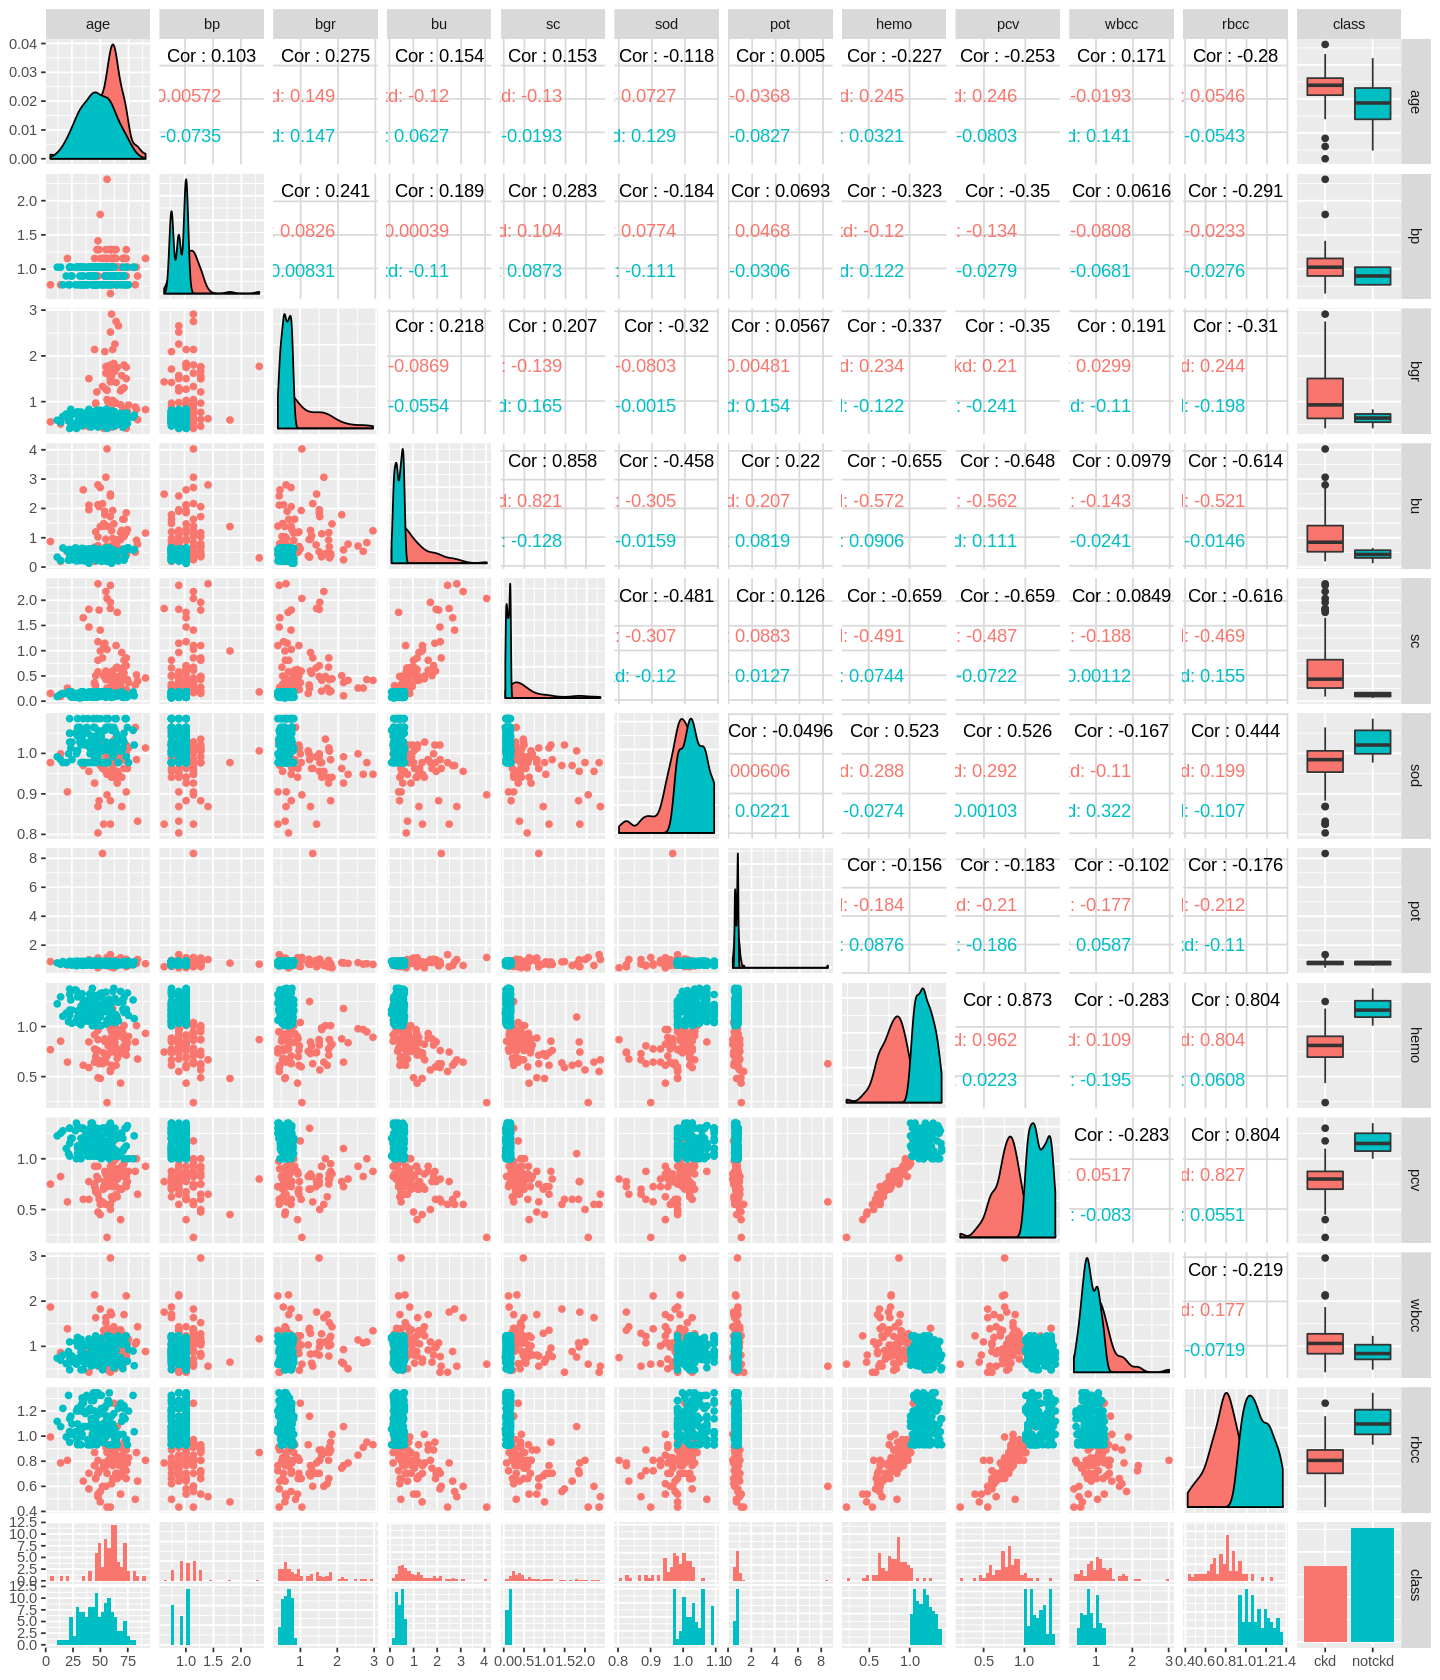

In [22]:
options(repr.plot.height = 14, repr.plot.width = 12)
 


kidney_total <- ggpairs(data = kidney_nona, mapping=ggplot2::aes(colour = class))
kidney_total

Warning message:
“Removed 73 rows containing missing values (geom_point).”

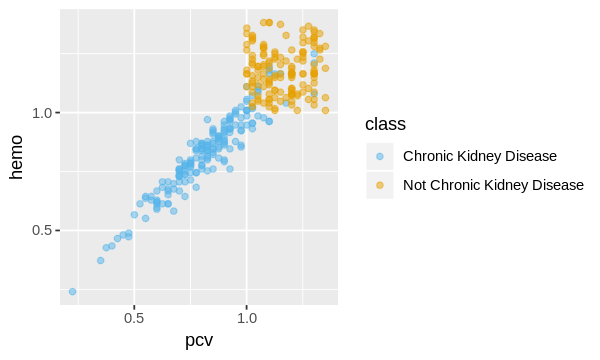

In [23]:
#hemo, pcv, rbcc, sod, sc

cbPalette <- c("#56B4E9", "#E69F00","#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

options(repr.plot.height = 3, repr.plot.width = 5)

kidney_plot <- kidney_scaled %>% 
    ggplot(aes(x = pcv, y = hemo, colour = class)) +
    geom_point(alpha = 0.5) +
    scale_color_manual(labels = c("Chronic Kidney Disease", "Not Chronic Kidney Disease"), values = cbPalette)

kidney_plot

In [28]:
set.seed(1234)

set_rows <- kidney_scaled %>% 
    select(class) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE) #CHECK TO SEE IF THIS IS RANDOMIZED

head(set_rows)

training_kidney <- kidney_scaled %>% slice(set_rows)
validation_kidney <- kidney_scaled %>% slice(-set_rows)

tail(validation_kidney)
tail(training_kidney)

Resample1
2
3
5
6
8
9


,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
94,30,1.0278113,0.4873324,0.5474681,0.1070967,1.056910,0.8864035,1.156466,1.125856,1.0527302,1.2207462,notckd
95,79,1.0278113,0.6596817,0.5735380,0.1835944,1.056910,0.6382105,1.265127,1.000760,0.8959406,1.3241993,notckd
96,64,0.8993349,0.5764786,0.3519438,0.1070967,1.049671,0.8509473,1.071089,1.225932,0.7167525,0.9931494,notckd
97,48,1.0278113,0.4457309,0.2867690,0.1223963,0.991758,0.8864035,1.303935,1.275970,0.6719554,1.3448899,notckd
98,41,1.0278113,0.6656247,0.6256778,0.1070967,1.013475,0.8864035,1.319458,1.300989,0.8063465,1.2000556,notckd
99,57,1.0278113,0.7904294,0.6256778,0.1835944,1.064149,0.7623070,1.148704,1.150875,0.7391510,1.1379837,notckd


,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
293,50,1.0278113,0.8142017,0.5996079,0.12239626,1.0062362,0.8864035,1.094374,1.125856,1.0639294,0.9517682,notckd
294,55,1.0278113,0.8320309,0.6387128,0.07649767,1.0858664,0.8686754,1.218558,1.175894,0.7503502,1.0138401,notckd
295,42,0.8993349,0.4457309,0.4040836,0.18359440,1.0207144,0.6204824,1.280650,1.351027,0.8735420,1.2828180,notckd
296,12,1.0278113,0.5943078,0.3389088,0.09179720,0.9917580,0.7800350,1.226319,1.225932,0.7391510,1.1172931,notckd
297,17,0.7708585,0.6775109,0.6517477,0.15299533,0.9772798,0.8686754,1.102135,1.275970,0.8063465,1.2207462,notckd
298,58,1.0278113,0.7785432,0.2346292,0.16829486,1.0207144,0.6204824,1.226319,1.326008,0.7615495,1.2621274,notckd


In [9]:
#hemo, pcv, rbcc, sod, sc
ks = data.frame(k = c(1, 3, 5, 7, 9))

training_hemo <- training_kidney %>% 
    select(hemo) %>% 
    data.frame()
#training_pcv
#training_rbcc
#training_sod
#training_sc

k-Nearest Neighbors 

120 samples
  2 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 120, 120, 120, 120, 120, 120, ... 
Resampling results:

  Accuracy   Kappa   
  0.7655672  0.339361

Tuning parameter 'k' was held constant at a value of 3

In [10]:
kidney_stats <- t_kidney_clean %>% 
    group_by(class) %>% 
    map_df(mean)

head(kidney_stats)
tail(t_kidney_clean)


Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.defaul

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
49.04167,73.58333,1.020125,0.7666667,0.25,NA,NA,NA,NA,133.9333,⋯,42.43333,8550,4.841667,NA,NA,NA,NA,NA,NA,NA


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
50,80,1.020,0,0,normal,normal,notpresent,notpresent,137,⋯,45,9500,4.6,no,no,no,good,no,no,notckd
55,80,1.020,0,0,normal,normal,notpresent,notpresent,140,⋯,47,6700,4.9,no,no,no,good,no,no,notckd
42,70,1.025,0,0,normal,normal,notpresent,notpresent,75,⋯,54,7800,6.2,no,no,no,good,no,no,notckd
12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,⋯,49,6600,5.4,no,no,no,good,no,no,notckd
17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,⋯,51,7200,5.9,no,no,no,good,no,no,notckd
58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,⋯,53,6800,6.1,no,no,no,good,no,no,notckd
